In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


rcParams['figure.figsize'] = 35, 10

In [2]:
data = pd.read_csv("restaurant-1-orders.csv")

In [3]:
data['Item Name'].value_counts()

Pilau Rice            4721
Plain Naan            3753
Plain Papadum         3598
Garlic Naan           2628
Onion Bhajee          2402
                      ... 
Tandoori Chicken         1
Lamb Persian             1
Chicken Chaat Main       1
Kurma                    1
Mushroom - Prawn         1
Name: Item Name, Length: 248, dtype: int64

In [4]:
#total products für die nächsten 7 tage (für die top 10 produkte)

data.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [5]:
#slect only needed columns
data_port = data[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
data_port = data_port.dropna()

In [6]:
#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')

In [7]:
data_ts = data_port[["Order Date", "Quantity"]]

In [8]:
data_ts.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)

In [9]:
data_ts.sort_values(by='ds', inplace=True)

In [10]:
indexedDataset = data_ts.set_index(['ds'])

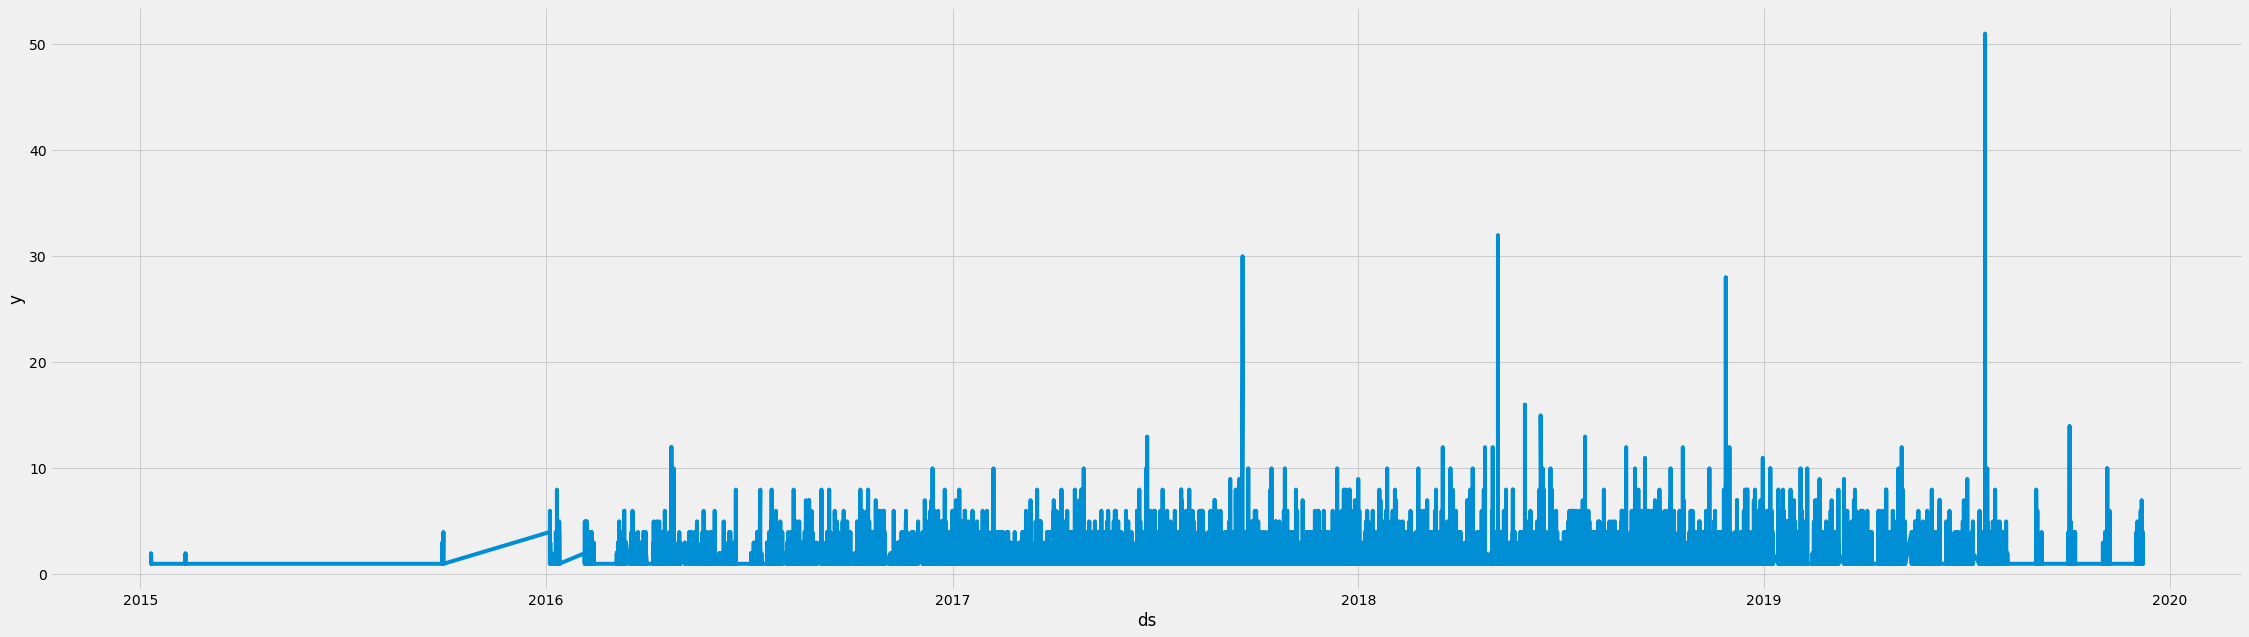

In [11]:
plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

# ARIMA https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima

<AxesSubplot:ylabel='Density'>

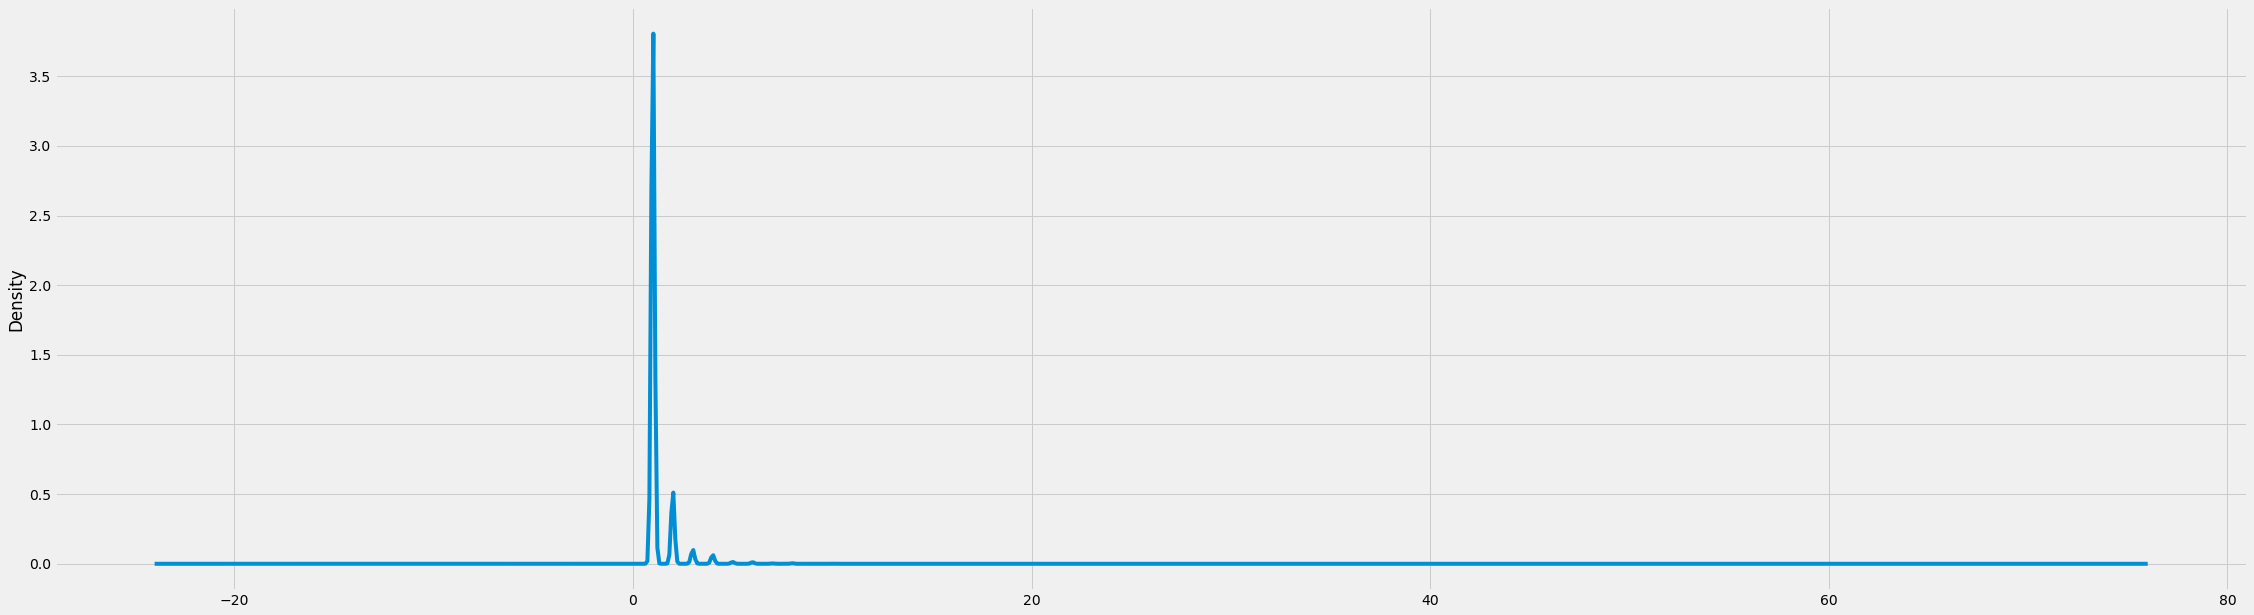

In [12]:
data_ts.y.plot(kind='kde')

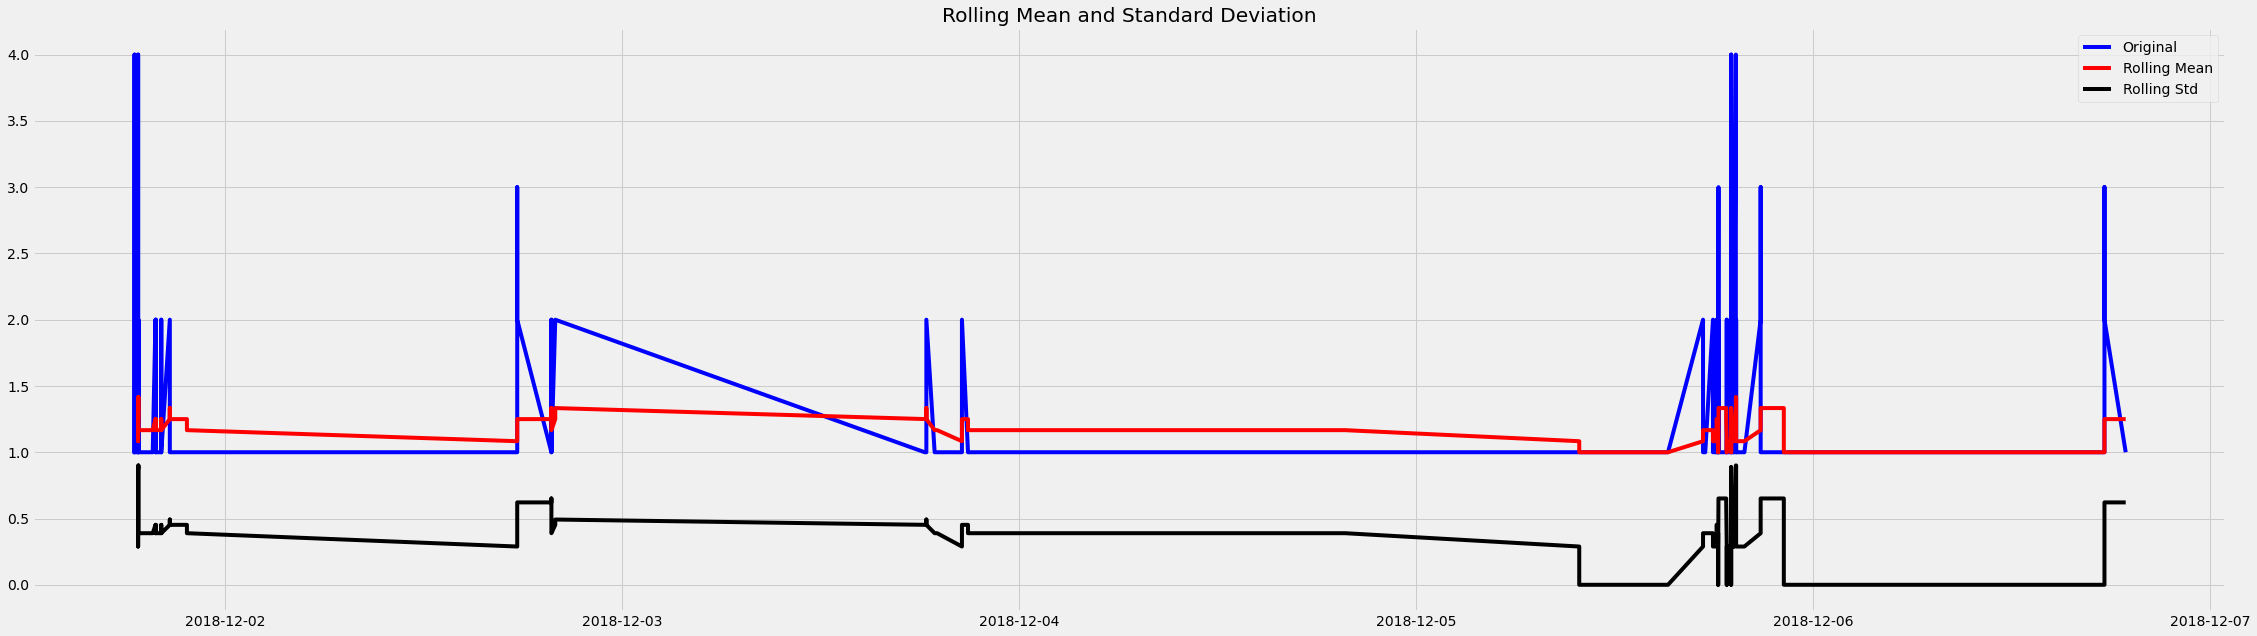

Results of dickey fuller test
Test Statistics               -1.575410e+01
p-value                        1.213462e-28
No. of lags used               0.000000e+00
Number of observations used    2.990000e+02
critical value (1%)           -3.452411e+00
critical value (5%)           -2.871255e+00
critical value (10%)          -2.571947e+00
dtype: float64


In [13]:
#filterslide
indexedDataset=indexedDataset[len(indexedDataset)-20530:len(indexedDataset)-20230]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 2520x720 with 0 Axes>

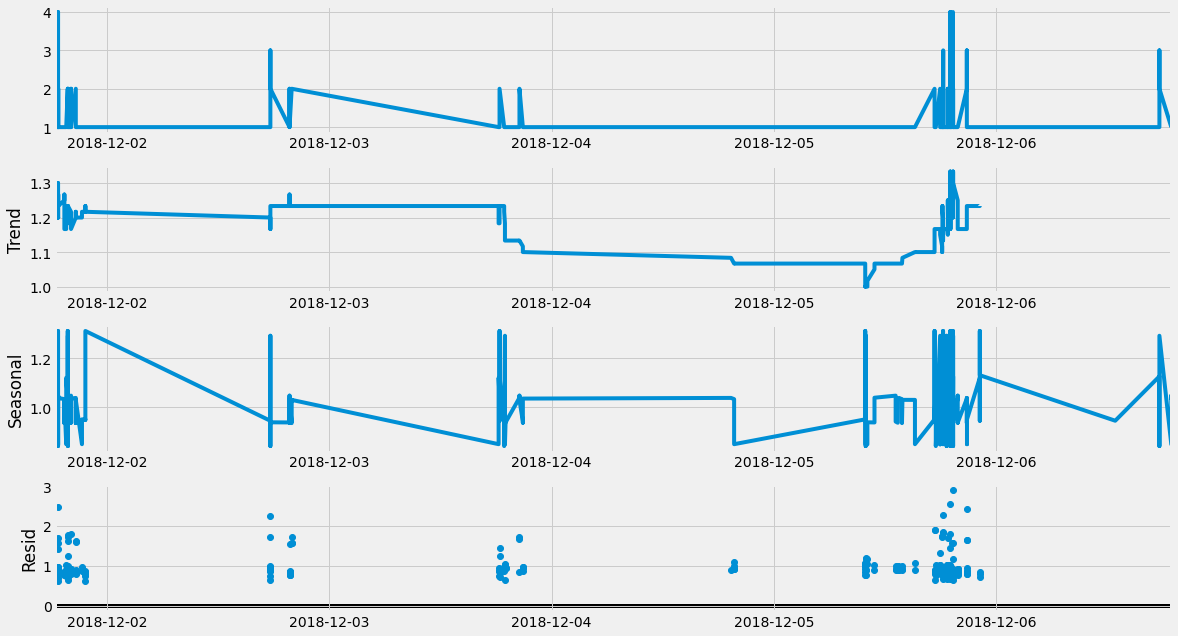

In [14]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


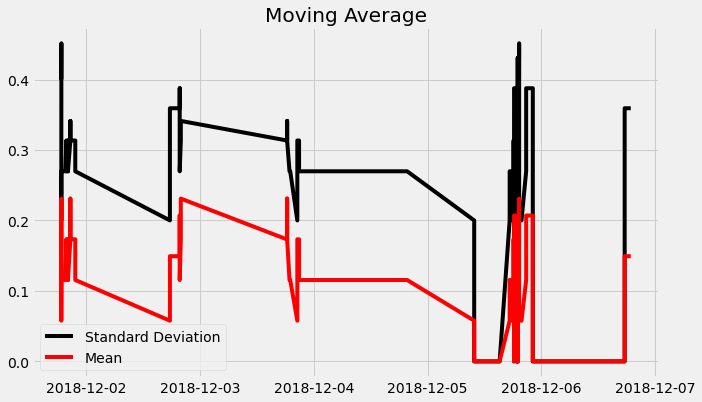

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(indexedDataset)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

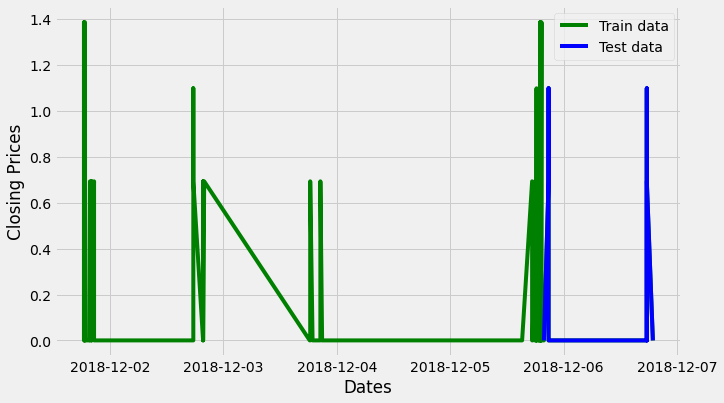

In [16]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=132.390, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=121.379, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=122.083, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=123.356, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=123.341, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=125.368, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.057, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=96.704, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=95.477, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=95.800, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=92.761, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97.078, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=94.760, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=94.761, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=93.163, Time=

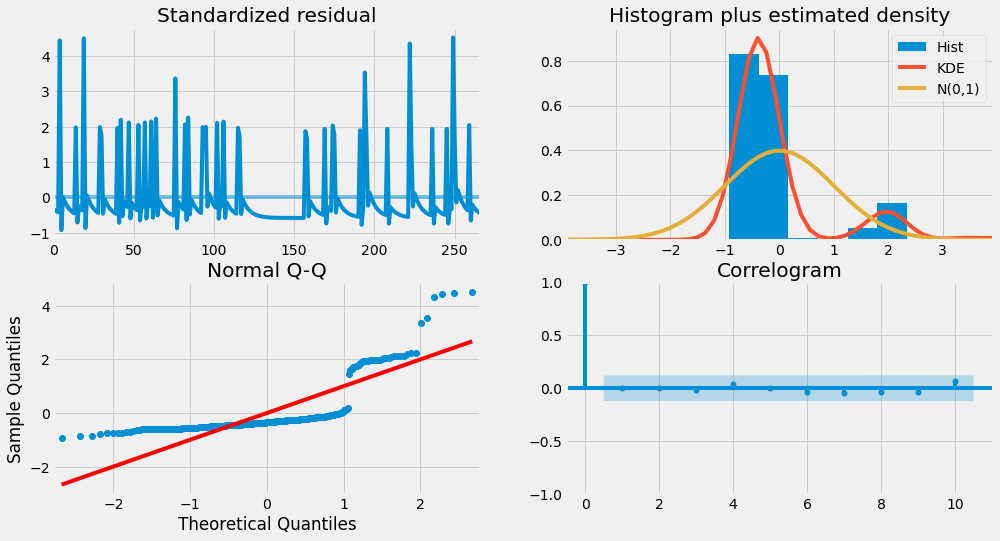

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  267
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -48.367
Date:                Mon, 18 Jul 2022   AIC                            104.734
Time:                        20:57:26   BIC                            119.068
Sample:                             0   HQIC                           110.492
                                - 267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9425      0.057    -16.452      0.000      -1.055      -0.830
ma.L1         -0.0254      0.681     -0.037      0.970      -1.361       1.310
ma.L2         -0.9742      0.657     -1.483      0.1

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
anzahl=len(test_data)

In [20]:
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

In [22]:


lower_series = pd.Series(conf['lower y'])
lower_series.index = index

In [23]:


upper_series = pd.Series(conf['upper y'])
upper_series.index = index

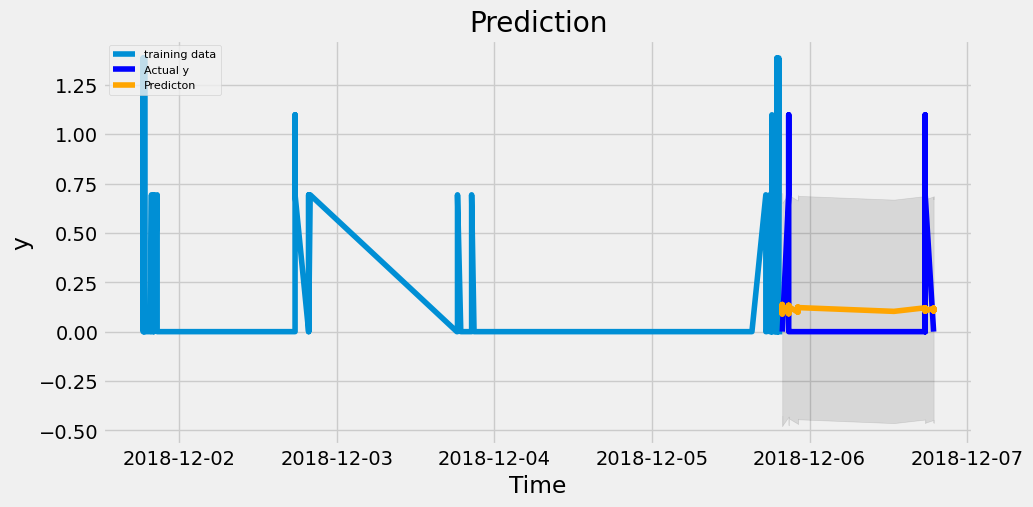

In [24]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))


MSE: 0.10865151060772539
MAE: 0.2165021947836004
RMSE: 0.32962328590032197


### Fazit gute Bereichsvorhersage aber riesen nachteil dass ARIMA keine Seasionality unterstützt

# SAMIRA

In [26]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()

In [27]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')

In [28]:

dd = ds[["Order Date", "Quantity"]]
dd.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

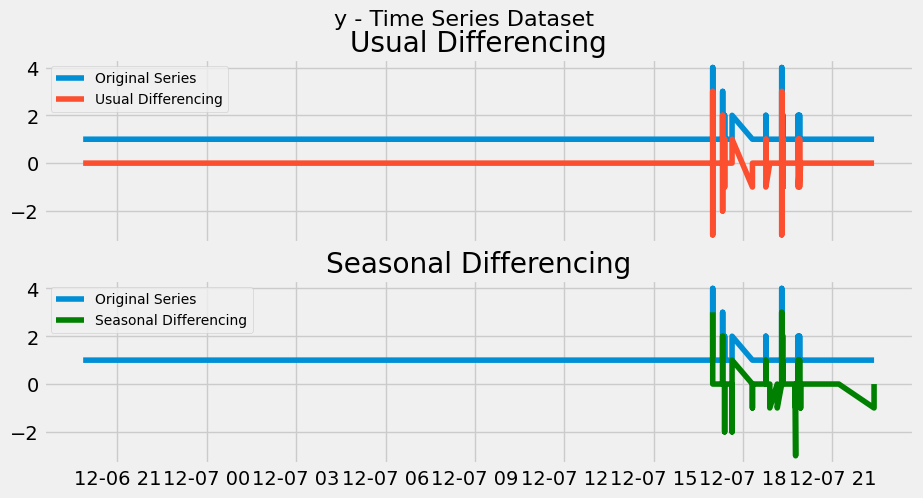

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

In [30]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(indexeddf, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=207.437, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=184.189, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=205.437, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=209.281, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=179.469, Time=0.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=177.576, Time=0.19 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=182.549, Time=0.06 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=179.439, Time=0.22 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=0.90

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  100
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                 -84.858
Date:                  Mon, 18 Jul 2022   AIC                            175.717
Time:                          20:57:34   BIC                            183.149
Sample:                               0   HQIC                           178.711
                                  - 100                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6845      0.065    -10.535      0.000      -0.812      -0.557
ar.S.L24      -0.2921      0.063     -4.610      0.000      -0.416      -0.168
sigma2         0.3759      0.026     14.479      0.000       0.325       0.427
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               305.02
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             1.96
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

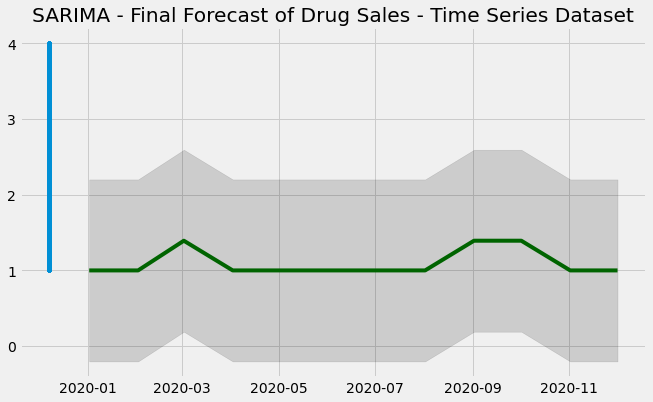

In [31]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

# Modelle für die Top 2 Kategorien

In [32]:
data = pd.read_csv("restaurant-1-orders.csv")
data['Item Name'].value_counts()

Pilau Rice            4721
Plain Naan            3753
Plain Papadum         3598
Garlic Naan           2628
Onion Bhajee          2402
                      ... 
Tandoori Chicken         1
Lamb Persian             1
Chicken Chaat Main       1
Kurma                    1
Mushroom - Prawn         1
Name: Item Name, Length: 248, dtype: int64

## 1 Model: ARIMA Cat: Pilau Rice

In [33]:
data.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [34]:
ds=data[data['Item Name']== 'Pilau Rice']

In [35]:
#slect only needed columns
data_port = ds[["Order Date", "Product Price", "Quantity", "Total products"]]
# drop NaN-Cases
data_port = data_port.dropna()

In [36]:

#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')

In [37]:

data_ts = data_port[["Order Date", "Quantity"]]

In [38]:

data_ts

,Order Date,Quantity
24,2019-03-08 20:01:00,1
29,2019-03-08 19:42:00,1
36,2019-03-08 19:29:00,1
65,2019-03-08 19:25:00,1
73,2019-03-08 19:16:00,1
...,...,...
29742,2016-03-18 19:24:00,1
29744,2016-03-18 18:56:00,1
29745,2016-03-18 18:54:00,1
29756,2016-03-17 19:56:00,1


In [39]:
data_ts.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)

In [40]:
data_ts.sort_values(by='ds', inplace=True)

<AxesSubplot:>

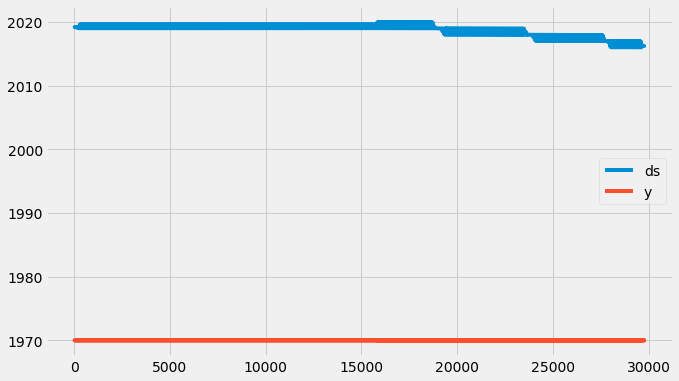

In [41]:


data_ts.plot()

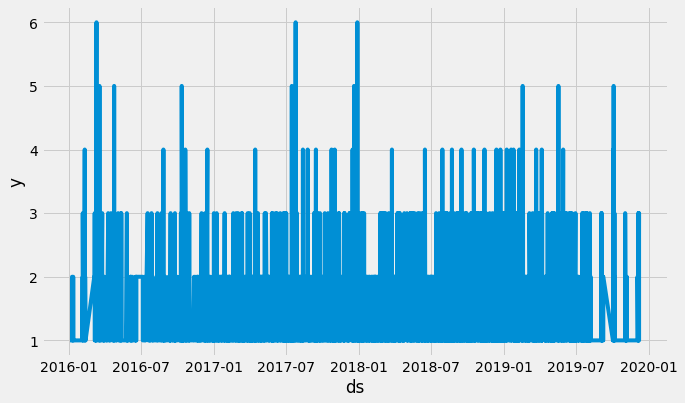

In [42]:
indexedDataset = data_ts.set_index(['ds'])

plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

In [43]:
indexedDataset

,y
ds,
2016-01-04 18:52:00,1
2016-01-04 19:33:00,1
2016-01-04 20:22:00,1
2016-01-04 21:07:00,1
2016-01-04 21:59:00,1
...,...
2019-12-06 18:42:00,1
2019-12-06 19:06:00,1
2019-12-07 17:19:00,1


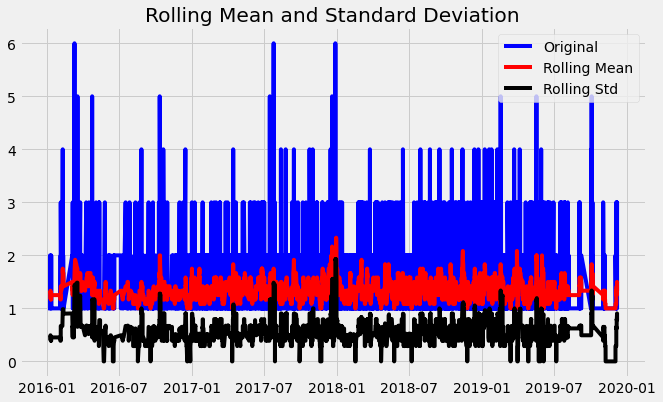

Results of dickey fuller test
Test Statistics                 -67.957232
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    4720.000000
critical value (1%)              -3.431736
critical value (5%)              -2.862153
critical value (10%)             -2.567096
dtype: float64


In [44]:
#filterslide
#indexedDataset=indexedDataset[len(indexedDataset)-200:len(indexedDataset)-150]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 720x432 with 0 Axes>

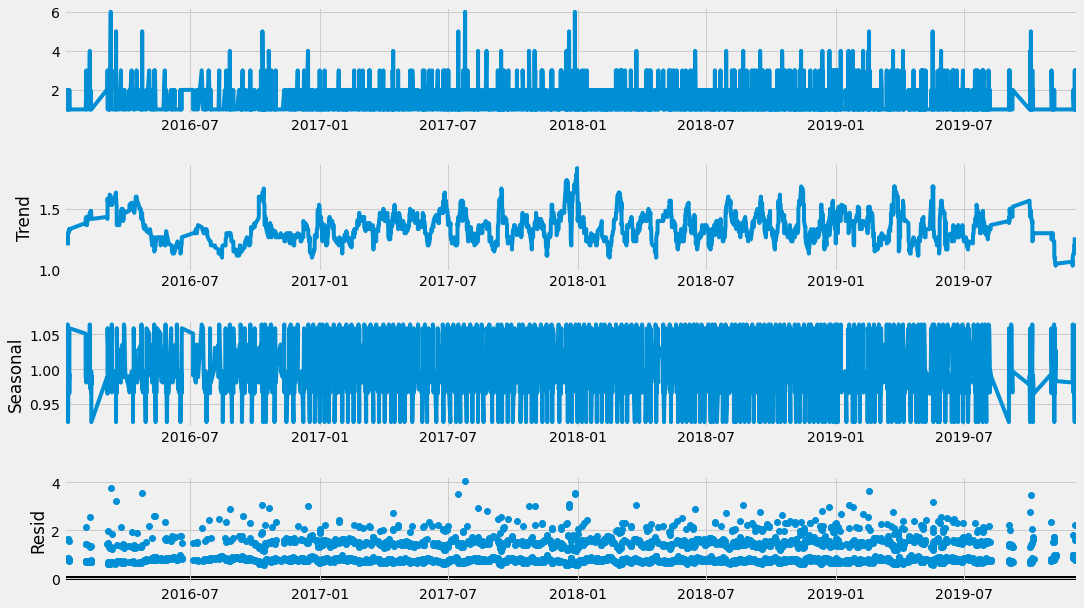

In [45]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


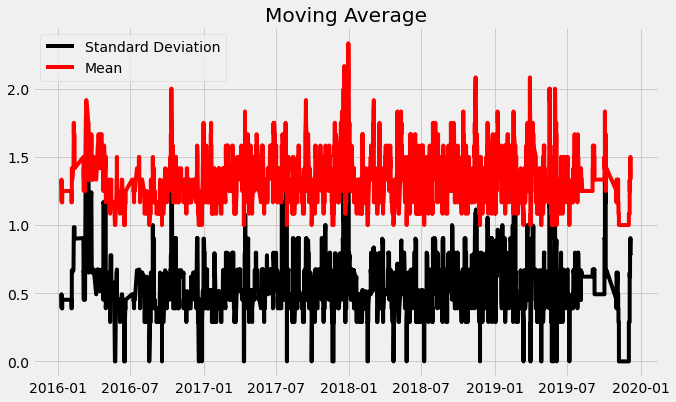

In [46]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#df_log = np.log(indexedDataset)
df_log = indexedDataset


moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

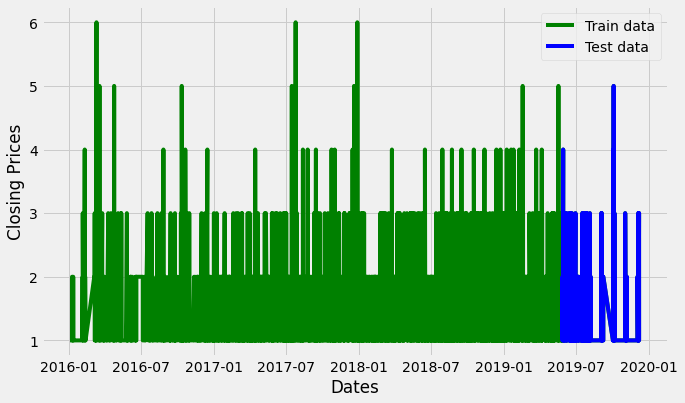

In [47]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15446.396, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10618.810, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13201.984, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9743.207, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9332.113, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8149.233, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8147.913, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8147.075, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8146.600, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8147.025, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8146.663, Time=1.71 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 6.001 seconds
                             

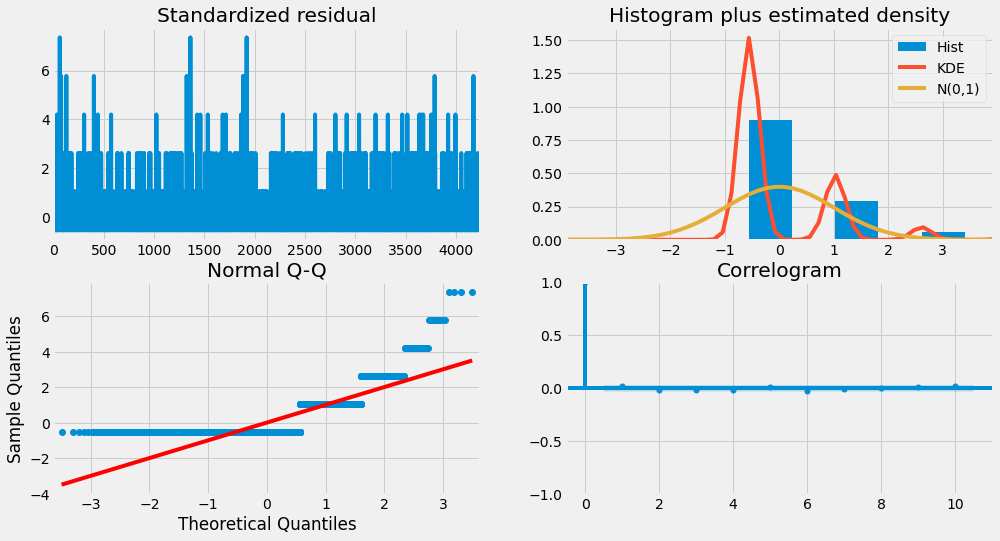

In [48]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [49]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4245
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4073.023
Date:                Mon, 18 Jul 2022   AIC                           8154.046
Time:                        20:57:43   BIC                           8179.459
Sample:                             0   HQIC                          8163.027
                               - 4245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8614      0.119     -7.236      0.000      -1.095      -0.628
ma.L1         -0.1229      0.114     -1.081      0.280      -0.346       0.100
ma.L2         -0.8770      0.115     -7.598      0.0

In [50]:
anzahl=len(test_data)
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [51]:


index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

lower_series = pd.Series(conf['lower y'])
lower_series.index = index

upper_series = pd.Series(conf['upper y'])
upper_series.index = index

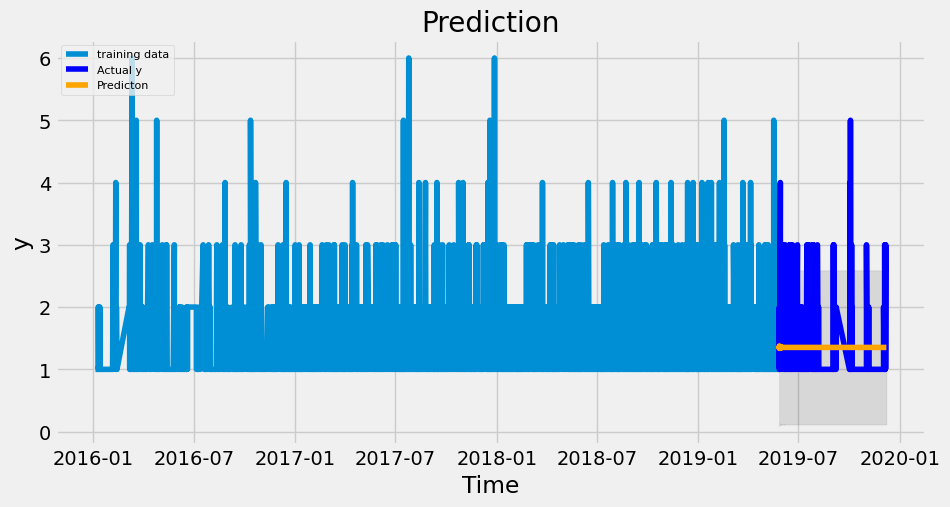

In [52]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.37527519788165764
MAE: 0.49457414436141883
RMSE: 0.6125970926160665


##  2 Model: ARIMA Cat: Plain Naan

In [54]:
data = pd.read_csv("restaurant-1-orders.csv")
ds=data[data['Item Name']== 'Plain Naan']
#slect only needed columns
data_port = ds[["Order Date", "Product Price", "Quantity", "Total products"]]
# drop NaN-Cases
data_port = data_port.dropna()
#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')
data_ts = data_port[["Order Date", "Quantity"]]
data_ts

,Order Date,Quantity
6,2019-03-08 20:17:00,1
46,2019-03-08 19:28:00,1
88,2019-03-08 18:36:00,1
128,2019-03-08 17:18:00,1
134,2019-03-08 16:21:00,2
...,...,...
15500,2016-03-18 19:05:00,1
15501,2016-03-18 18:54:00,1
15502,2016-03-18 18:08:00,1
15503,2016-03-17 18:52:00,1


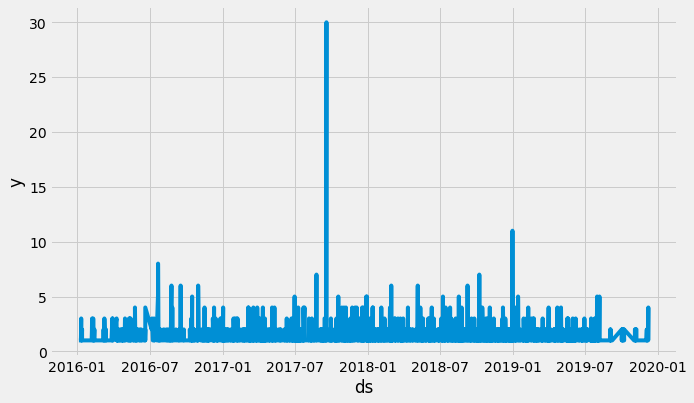

In [55]:
data_ts.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)
data_ts.sort_values(by='ds', inplace=True)
indexedDataset = data_ts.set_index(['ds'])

plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

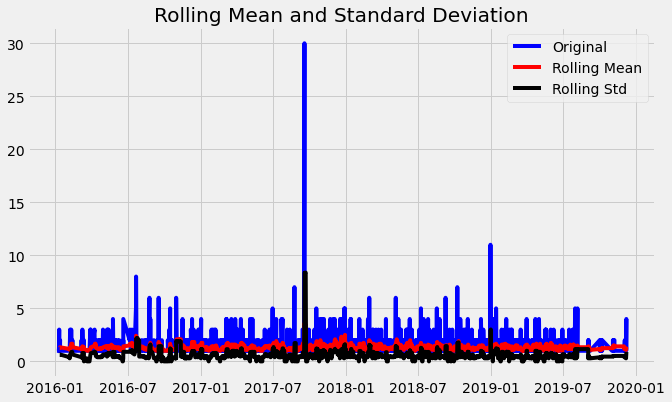

Results of dickey fuller test
Test Statistics                 -59.496343
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    3752.000000
critical value (1%)              -3.432094
critical value (5%)              -2.862311
critical value (10%)             -2.567180
dtype: float64


In [56]:
#filterslide
#indexedDataset=indexedDataset[len(indexedDataset)-200:len(indexedDataset)-150]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 720x432 with 0 Axes>

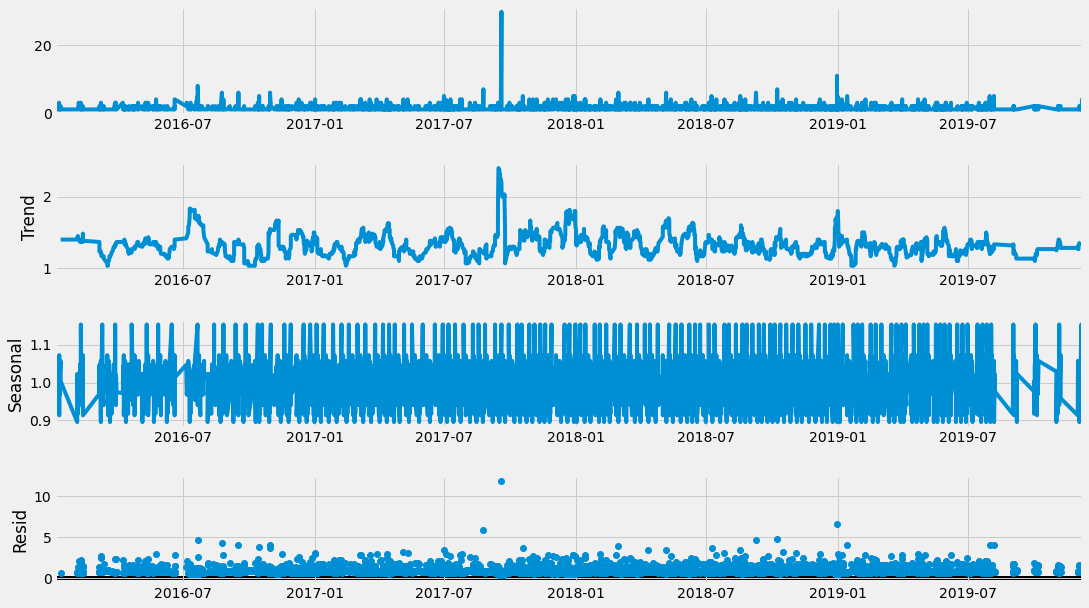

In [57]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


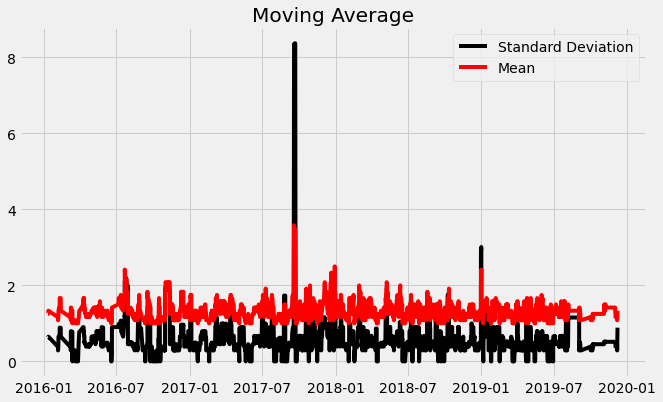

In [58]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#df_log = np.log(indexedDataset)
df_log = indexedDataset

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

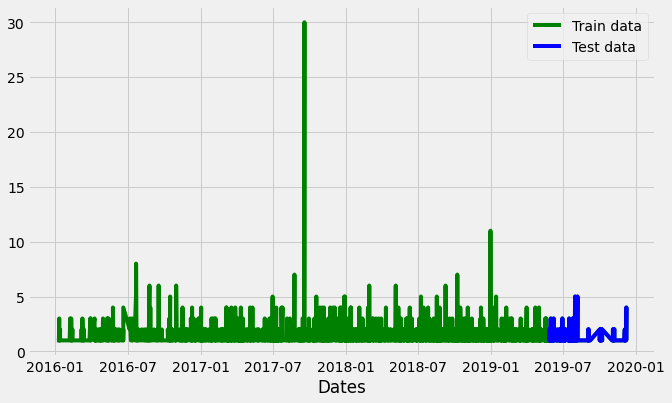

In [59]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')

plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12708.327, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10341.255, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11481.912, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9780.387, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9476.739, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8625.498, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8623.613, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8622.103, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8622.623, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8623.497, Time=1.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8622.042, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8623.592, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AI

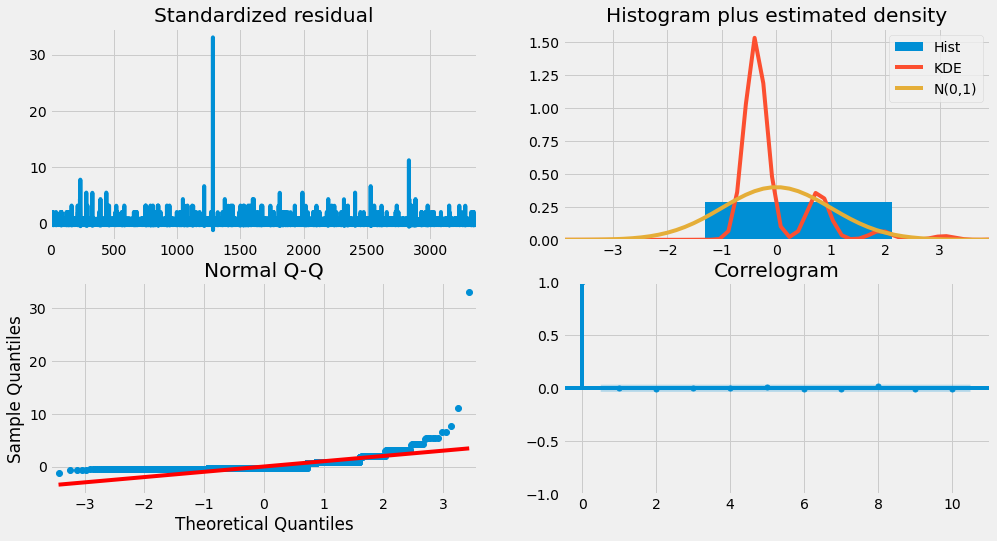

In [60]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [61]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3374
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4310.631
Date:                Mon, 18 Jul 2022   AIC                           8629.262
Time:                        20:57:51   BIC                           8653.756
Sample:                             0   HQIC                          8638.020
                               - 3374                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4330      0.514     -0.842      0.400      -1.441       0.575
ma.L1         -0.5383      0.511     -1.054      0.292      -1.539       0.462
ma.L2         -0.4592      0.509     -0.901      0.3

In [62]:
anzahl=len(test_data)
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

lower_series = pd.Series(conf['lower y'])
lower_series.index = index

upper_series = pd.Series(conf['upper y'])
upper_series.index = index

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


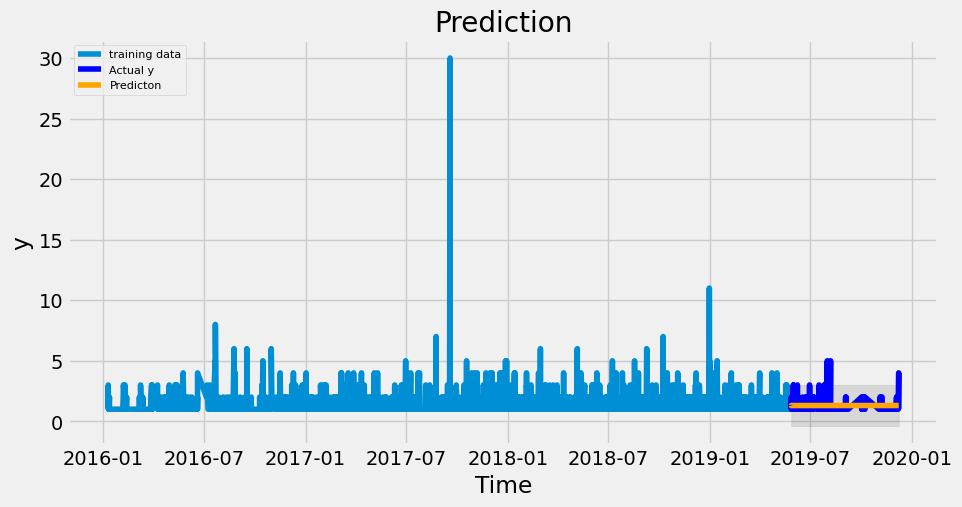

In [63]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [64]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.3209175653466032
MAE: 0.4393358789781699
RMSE: 0.5664958652511095


## 3 Model: SARIMA Cat: Plain Naan

In [65]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()
ds=data[data['Item Name']== 'Pilau Rice']

In [66]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')
dd = ds[["Order Date", "Quantity"]]
dd.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
#indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

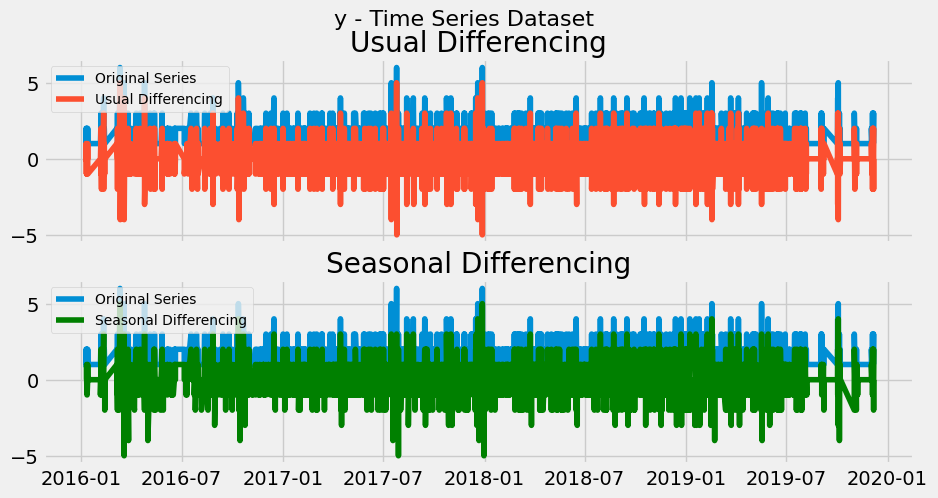

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

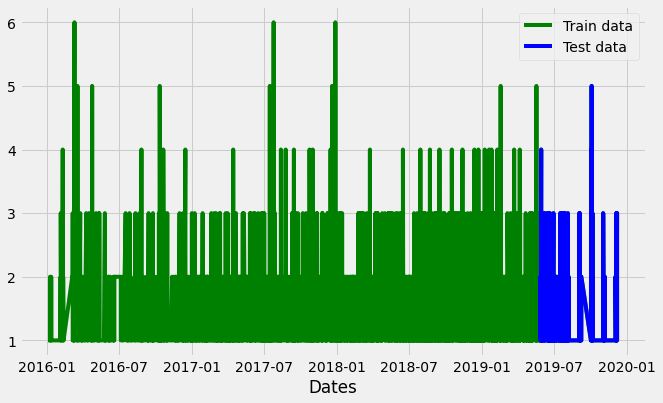

In [68]:
#split data into train and training set
train_data, test_data = indexeddf[3:int(len(indexeddf)*0.9)], indexeddf[int(len(indexeddf)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')

plt.plot(indexeddf, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [69]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11126.319, Time=0.51 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=9911.804, Time=1.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11124.319, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11128.313, Time=0.29 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=9354.914, Time=7.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=30.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9354.131, Time=6.12 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=9911.132, Time=1.42 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.18 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.87 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=9354.876, Time=6.95 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                 4245
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -4673.065
Date:                  Mon, 18 Jul 2022   AIC                           9352.131
Time:                          21:00:53   BIC                           9371.183
Sample:                               0   HQIC                          9358.865
                                 - 4245                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6760      0.011    -62.248      0.000      -0.697      -0.655
ar.S.L24      -0.3520      0.011    -32.141      0.000      -0.373      -0.330
sigma2         0.5318      0.008     69.613      0.000       0.517       0.547
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):              2104.77
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.13
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

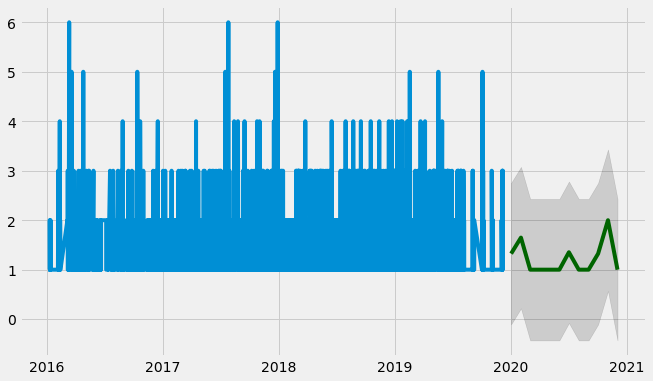

In [70]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)


plt.show()

## 4 Model: SARIMA Cat: Plain Naan

In [71]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()
ds=data[data['Item Name']== 'Plain Naan']

In [72]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')
dd = ds[["Order Date", "Quantity"]]
dd.rename(columns= {'Order Date':'ds', 'Quantity':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
#indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

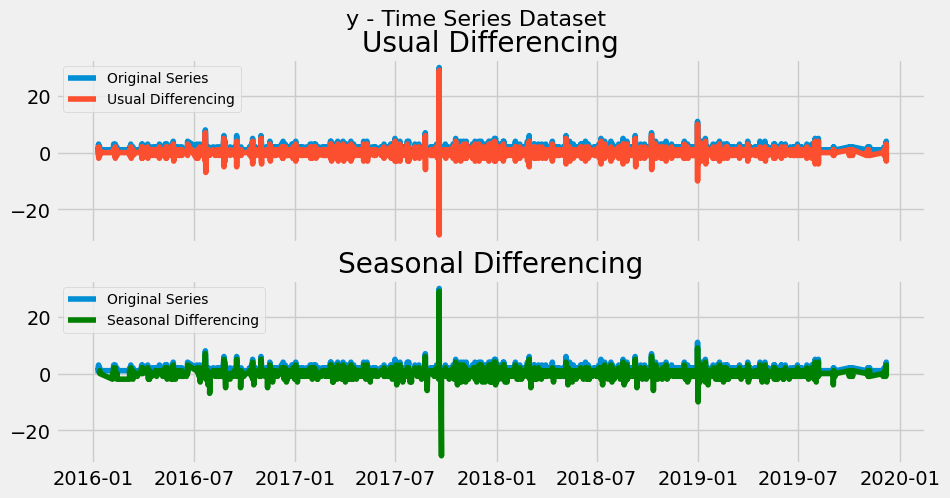

In [73]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

In [74]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(indexeddf, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11988.764, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10883.020, Time=1.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11986.765, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11989.746, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10409.587, Time=5.94 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=23.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=10409.351, Time=4.47 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=10882.941, Time=0.93 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.50 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=10409.555, Time=5.53 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                 3753
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -5200.676
Date:                  Mon, 18 Jul 2022   AIC                          10407.352
Time:                          21:02:38   BIC                          10426.033
Sample:                               0   HQIC                         10413.997
                                 - 3753                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6826      0.003   -241.323      0.000      -0.688      -0.677
ar.S.L24      -0.3457      0.003   -130.260      0.000      -0.351      -0.341
sigma2         0.9424      0.002    460.296      0.000       0.938       0.946
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):           7917453.49
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             7.59
Prob(H) (two-sided):                  0.01   Kurtosis:                       227.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

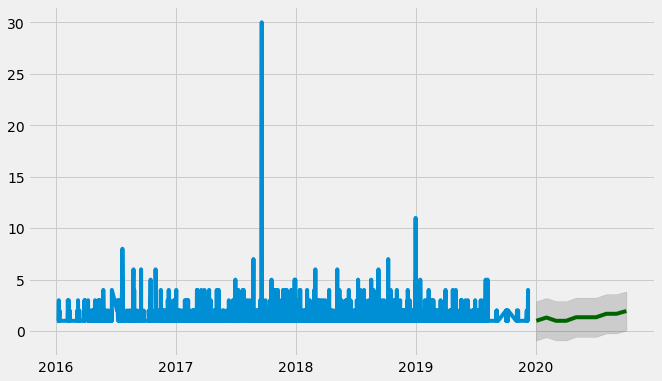

In [75]:
# Forecast
n_periods = 10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()